In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed


## Creating a table sequence

Selection of a 50Hz frequency : 

In [2]:
dt = 1/50

In [3]:
step_plot = 50

We have to choose the position of the table e.g. Paris :

In [4]:
lat_Paris = 48.8534 # degrees
lon_Paris = 2.3488  # degrees
alt_Paris = 35      # meters

And the inital attitude of the table :

In [5]:
h0, p0, r0 = 45, 8, 15 

In [6]:
seq = pd.DataFrame()
seq['rest_time'] = np.array([1205, 20, 1000, 1000])
seq['angle'] = np.array([95, -95, 95, 0])
seq['axis'] = np.array([0, 1, 2, 0])
seq

,rest_time,angle,axis
0,1205,95,0
1,20,-95,1
2,1000,95,2
3,1000,0,0


In [7]:
from pyins import sim

In [8]:
Table = sim.TableRotations(dt, h0, p0, r0)
for i in seq.index:
    Table.rest(seq['rest_time'][i])
    Table.rotate(seq['axis'][i], seq['angle'][i])

We can visualize the sequence thanks to Jupiter's interact function :

In [9]:
from helper import plot_nb

In [10]:
def f(t, dt, Cnb):
    n = int(t/dt)
    plot_nb(Cnb[n,:,:])
    
tf = Table.Cnb.shape[0]*dt
interact(f, t = (0, tf), Cnb = fixed(Table.Cnb), dt = fixed(dt), continuous_update=False);

interactive(children=(FloatSlider(value=1626.76, description='t', max=3253.52), Output()), _dom_classes=('widg…

### Generate inertial readings

Then we generate the inertial measurements :

In [11]:
gyros, accels = sim.stationary_rotation(dt, lat_Paris, alt_Paris, Table.Cnb)

The inertial readings are drawn below:

In [12]:
from helper import plot_inertial_readings

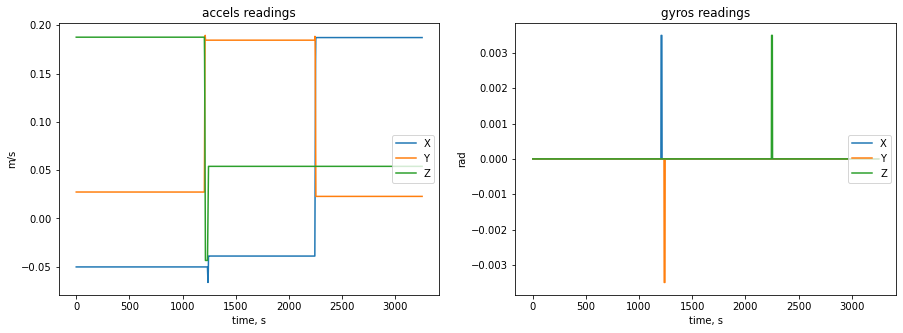

In [13]:
plot_inertial_readings(dt, gyros, accels, step_plot)

## Integrating ideal data

Just to check that everything is correct we want to integrate the generated gyro and accel readings.

In [14]:
from pyins.integrate import coning_sculling, integrate
from pyins.filt import traj_diff

First we apply coning and sculling corrections:

In [15]:
theta, dv = coning_sculling(gyros, accels)

And the run the integration.

In [16]:
traj_ideal = integrate(dt, lat_Paris, lon_Paris,0.0, 0.0, h0, p0, r0, theta, dv)

In [17]:
from helper import plot_traj

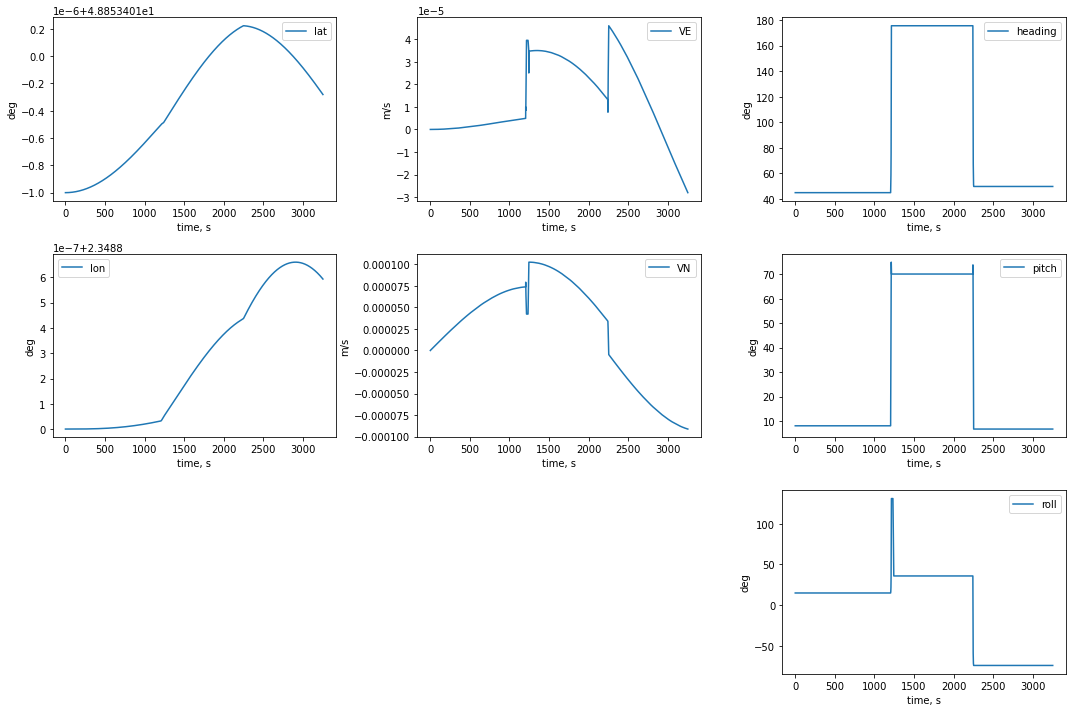

In [18]:
plot_traj(dt, traj_ideal, step_plot)

There is no lever arm modeled here, the body frame is confused with the measurement frame of the IMU so the velocity is -almost- zero. As it is evaluated in other pages, no significant integrator error is observed. The calculated one is supposed to be the reference trajectory.

## Integrating "real" data

Now we will run the navigation using inertial sensors with errors.

The error will be a sum of a random bias and additive white noise. We define magnitudes typical for moderately accurate navigation grade sensors.

In [19]:
gyro_bias_sd = np.deg2rad(0.05) / 3600  # 0.05 d/h
accel_bias_sd = 5e-3

In [20]:
gyro_noise = 1e-6  # rad / s^0.5
accel_noise = 3e-4  # m / s^1.5

Compute biases as a random constants. To avoid a "bad case" in this example we generated biases uniformly within $[-2 \sigma, 2 \sigma]$.

In [21]:
np.random.seed(1)

In [22]:
gyro_bias = gyro_bias_sd * np.random.uniform(-2, 2, 3)
accel_bias = accel_bias_sd * np.random.uniform(-2, 2, 3)

Now we apply errors to inertial readings:

In [23]:
gyro_e = gyros + gyro_bias * dt + gyro_noise * np.random.randn(*gyros.shape) * dt**0.5
accel_e = accels + accel_bias * dt + accel_noise * np.random.randn(*accels.shape) * dt**0.5

Compute coning and sculling corrections:

In [24]:
theta, dv = coning_sculling(gyro_e, accel_e)

It can be useful to observe the inertial errors of the sensors on a short window of 2min.

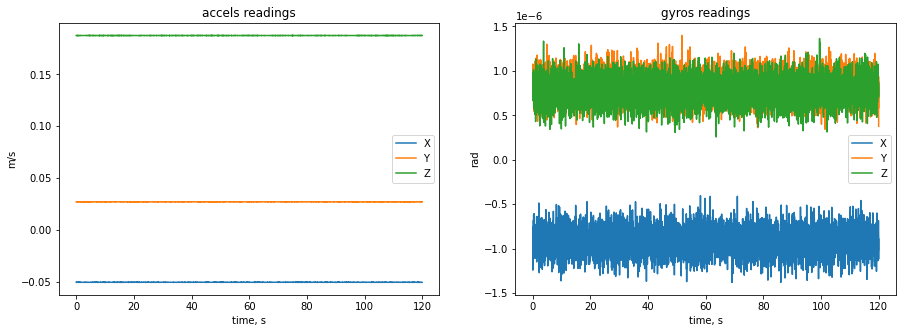

In [25]:
end = int(2*60/dt)
plot_inertial_readings(dt, theta[:end], dv[:end])

An INS operation have to start with the self alignment. We devote 15 minutes of the initial rest for it:

In [26]:
t_align = 15 * 60
align_samples = int(t_align / dt)

In [27]:
from pyins.align import align_wahba

In [28]:
(h0_aln, p0_aln, r0_aln), P_align = align_wahba(dt, theta[:align_samples], dv[:align_samples], lat_Paris)

Compare estimated attitude angles with the true angles.

In [29]:
h0_aln - traj_ideal.h.loc[align_samples], p0_aln - traj_ideal.p.loc[align_samples], r0_aln - traj_ideal.r.loc[align_samples]

(-0.1410016604956823, -0.04079845062938148, 0.042273192482124244)

And the run the integration.

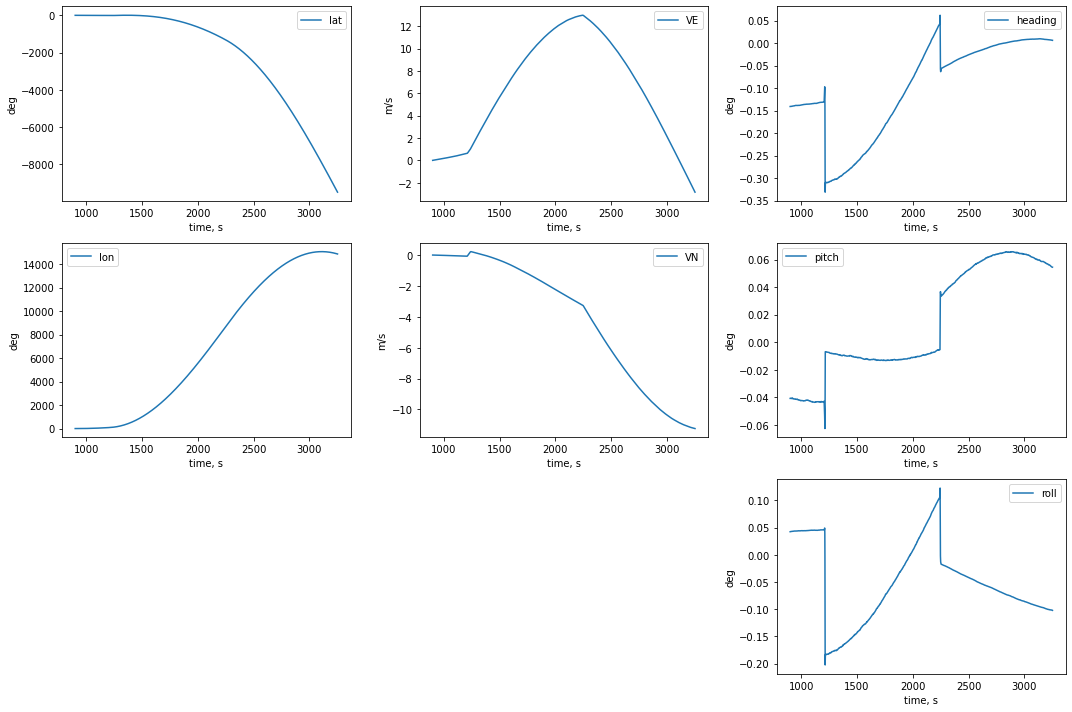

In [30]:
traj_real = integrate(dt, lat_Paris, lon_Paris, 0.0, 0.0,
                      h0_aln, p0_aln, r0_aln,
                      theta[align_samples:], dv[align_samples:],
                      stamp=align_samples)
err = traj_diff(traj_real, traj_ideal)
plot_traj(dt, err, step_plot)

## Aiding from Zero-velocity update (ZUPT)

Now we will use the fact that the INS is not moving in the main part of the time. This kind of evaluation is very useful for the calibration of INS sensors. The links between the velocity errors and inertial sensors errors allows us to estimate them quite well (for the gyros, the observation time may be important depending on the performance).

In [31]:
from pyins.filt import VeVnObs

In [32]:
vm_sd = 0.01 # m/s

In [33]:
vm_data = pd.DataFrame(index=traj_ideal.index[::10])
vm_data['VE'] = 0 + vm_sd * np.random.randn(*traj_ideal[::10].VE.shape)
vm_data['VN'] = 0 + vm_sd * np.random.randn(*traj_ideal[::10].VN.shape)

Plotting ZUPT measurements:

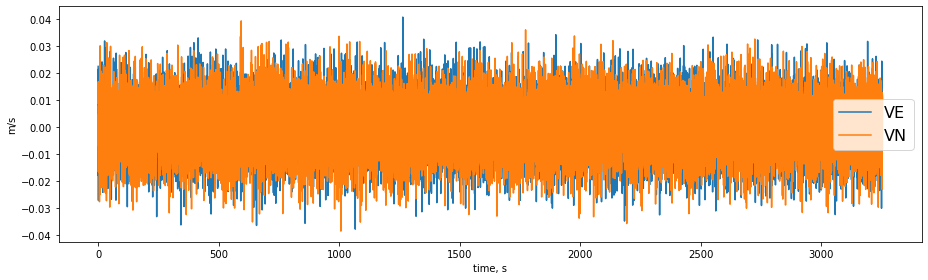

In [34]:
plt.figure(figsize=(13, 4))
plt.plot(traj_ideal.index[::10] * dt, vm_data.VE, label='VE')
plt.plot(traj_ideal.index[::10] * dt, vm_data.VN, label='VN')
plt.xlabel("time, s")
plt.ylabel("m/s")
plt.legend(fontsize=16, loc='center right')
plt.tight_layout()

To use ZUPT in a navigation Kalman filter we wrap this data into a special object:

In [35]:
from pyins.filt import VeVnObs

In [36]:
vm_obs = VeVnObs(vm_data, vm_sd)

Also define gyro and accelerometer models using parameters defined above:

In [37]:
from pyins.filt import InertialSensor

In [38]:
gyro_model = InertialSensor(bias=gyro_bias_sd, noise=gyro_noise)
accel_model = InertialSensor(bias=accel_bias_sd, noise=accel_noise)

Now we can run a navigation Kalman filter which will blend INS and ZUPT data. In this example INS errors didn't grow very large, thus we can use a feedforward filter.

In [39]:
from pyins.filt import FeedforwardFilter

We create a filter by passing sampling period and computed trajectory. To initialize the covariance matrix we pass standard deviations of the initial errors.

Currently the covariance matrix is initialized as diagonal. Theoretical attitude accuracy (sd values) from static gyrocompassing in our case is: 0.35 deg for heading (`azimuth_sd`) and 0.03 deg for pitch and roll (`level_sd`). Here we set values slightly higher to account for a non-perfect alignment:

In [40]:
ff_filt = FeedforwardFilter(dt, traj_real,
                            pos_sd=0.3, vel_sd=0.1, azimuth_sd=0.5, level_sd=0.05,
                            gyro_model=gyro_model, accel_model=accel_model)

We run the filter and pass available measurements to it. The return value is the INS trajectory corrected by estimated errors.

In [41]:
%%time
ff_res = ff_filt.run(observations=[vm_obs])

Wall time: 11.5 s


Now we want to investigate errors in the filtered trajectory. Below we plot true errors 
with their **3-sigma** bounds provided by the filter.

In [42]:
filt_error = traj_diff(ff_res.traj, traj_ideal)

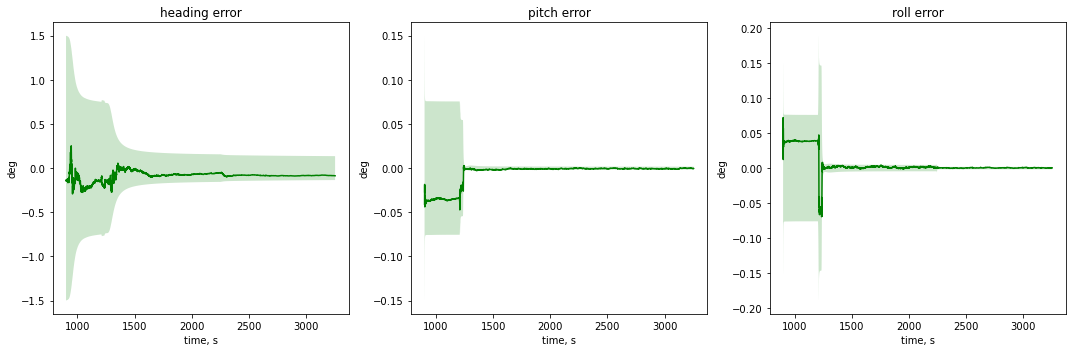

In [43]:
plt.figure(figsize=(15, 5))

t_plot = filt_error.index * dt

plt.subplot(131)
plt.plot(t_plot, filt_error.h, 'g')
plt.fill_between(t_plot, 3*ff_res.sd.h, -3*ff_res.sd.h, facecolor='g',alpha=0.2)
plt.xlabel("time, s")
plt.ylabel("deg")
plt.title("heading error")

plt.subplot(132)
plt.plot(t_plot, filt_error.p, 'g')
plt.fill_between(t_plot, 3*ff_res.sd.p, -3*ff_res.sd.p, facecolor='g',alpha=0.2)
plt.xlabel("time, s")
plt.ylabel("deg")
plt.title("pitch error")

plt.subplot(133)
plt.plot(t_plot,  filt_error.r, 'g')
plt.fill_between(t_plot, 3*ff_res.sd.r, -3*ff_res.sd.r, facecolor='g',alpha=0.2)
plt.xlabel("time, s")
plt.ylabel("deg")
plt.title("roll error")


plt.tight_layout()

Let's have a look on velocity and position estimation

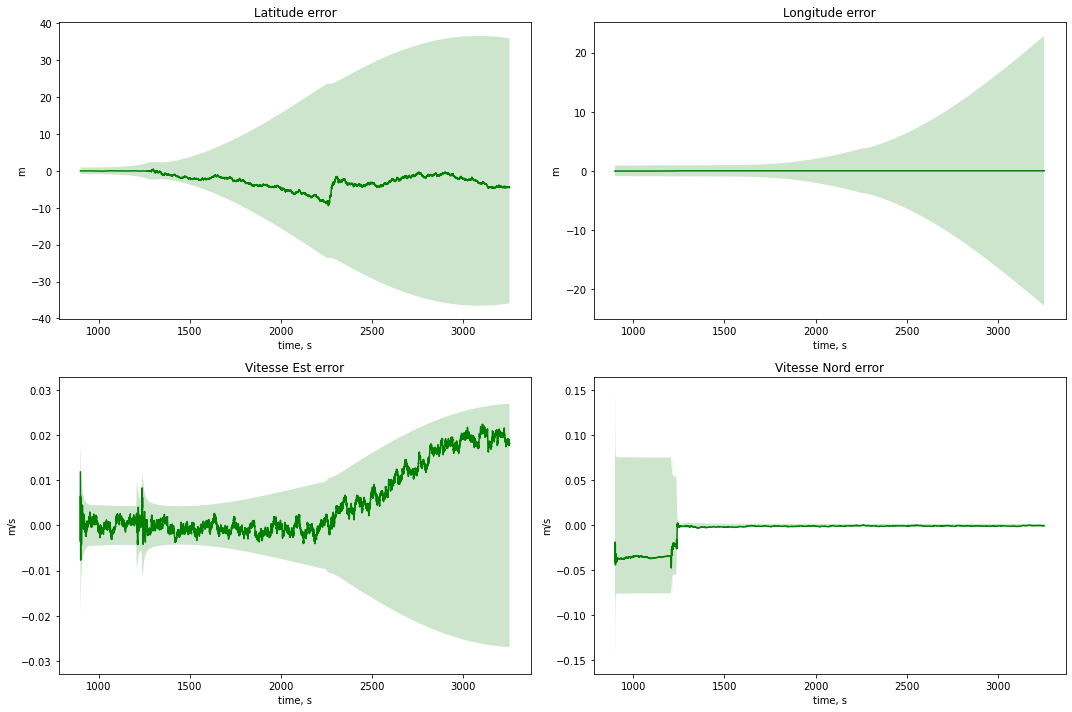

In [44]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(t_plot, filt_error.lat, 'g')
plt.fill_between(t_plot, 3*ff_res.sd.lat, -3*ff_res.sd.lat, facecolor='g',alpha=0.2)
plt.xlabel("time, s")
plt.ylabel("m")
plt.title("Latitude error")

plt.subplot(222)
plt.plot(t_plot, filt_error.p, 'g')
plt.fill_between(t_plot, 3*ff_res.sd.lon, -3*ff_res.sd.lon, facecolor='g',alpha=0.2)
plt.xlabel("time, s")
plt.ylabel("m")
plt.title("Longitude error")

plt.subplot(223)
plt.plot(t_plot, filt_error.VE, 'g')
plt.fill_between(t_plot, 3*ff_res.sd.VE, -3*ff_res.sd.VE, facecolor='g',alpha=0.2)
plt.xlabel("time, s")
plt.ylabel("m/s")
plt.title("Vitesse Est error")

plt.subplot(224)
plt.plot(t_plot, filt_error.p, 'g')
plt.fill_between(t_plot, 3*ff_res.sd.p, -3*ff_res.sd.p, facecolor='g',alpha=0.2)
plt.xlabel("time, s")
plt.ylabel("m/s")
plt.title("Vitesse Nord error")

plt.tight_layout()

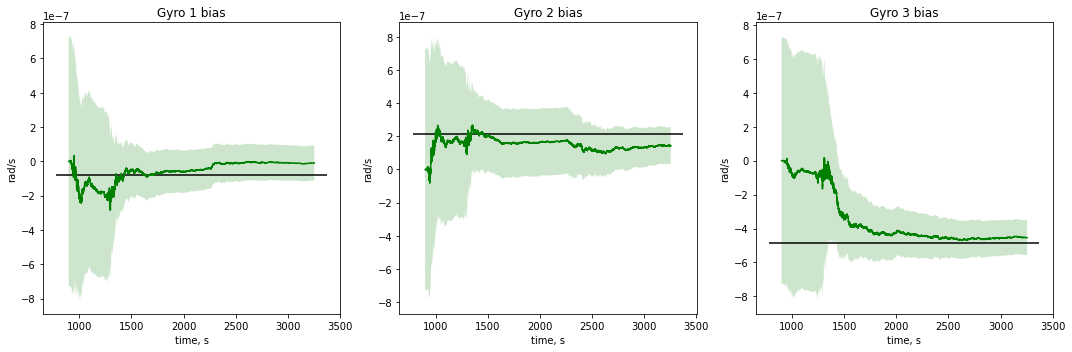

In [45]:
plt.figure(figsize=(15, 5))

t_plot = filt_error.index * dt

gyro_err = ff_res.gyro_err.iloc[::]
gyro_sd = ff_res.gyro_sd.iloc[::]

plt.subplot(131)
plt.plot(t_plot, gyro_err.BIAS_1, 'g')
plt.fill_between(t_plot, gyro_err.BIAS_1 - 3*gyro_sd.BIAS_1,
                         gyro_err.BIAS_1 + 3*gyro_sd.BIAS_1,
                         facecolor='g',alpha=0.2)
plt.hlines(gyro_bias[0], *plt.xlim())
plt.xlabel("time, s")
plt.ylabel("rad/s")
plt.title("Gyro 1 bias")

plt.subplot(132)
plt.plot(t_plot, gyro_err.BIAS_2, 'g')
plt.fill_between(t_plot, gyro_err.BIAS_2 - 3*gyro_sd.BIAS_2,
                         gyro_err.BIAS_2 + 3*gyro_sd.BIAS_2,
                         facecolor='g',alpha=0.2)
plt.hlines(gyro_bias[1], *plt.xlim())
plt.xlabel("time, s")
plt.ylabel("rad/s")
plt.title("Gyro 2 bias")

plt.subplot(133)
plt.plot(t_plot, gyro_err.BIAS_3, 'g')
plt.fill_between(t_plot, gyro_err.BIAS_3 - 3*gyro_sd.BIAS_3,
                         gyro_err.BIAS_3 + 3*gyro_sd.BIAS_3,
                         facecolor='g',alpha=0.2)
plt.hlines(gyro_bias[2], *plt.xlim())
plt.xlabel("time, s")
plt.ylabel("rad/s")
plt.title("Gyro 3 bias")

plt.tight_layout()

Below the same done for accelerometer biases. Horizontal accelerometer biases are less observable on the given trajectory than gyro biases, and the vertical bias is not observable at all because pitch and roll are held zero.

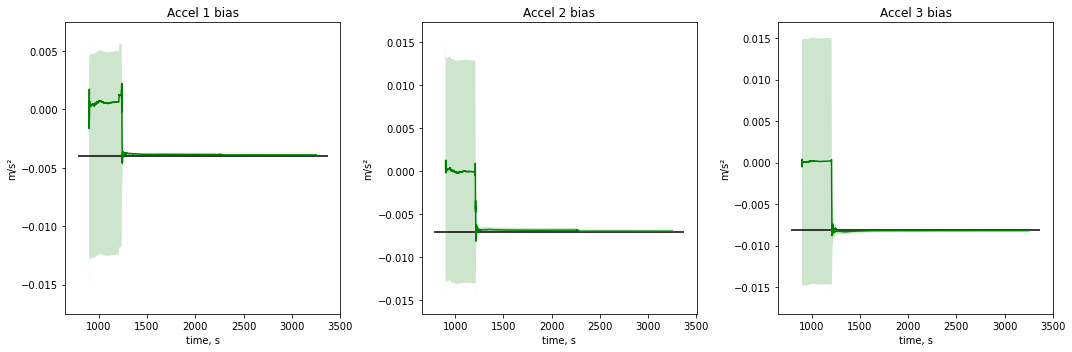

In [46]:
plt.figure(figsize=(15, 5))

t_plot = filt_error.index[::] * dt

accel_err = ff_res.accel_err.iloc[::]
accel_sd = ff_res.accel_sd.iloc[::]

plt.subplot(131)
plt.plot(t_plot, accel_err.BIAS_1, 'g')
plt.fill_between(t_plot, accel_err.BIAS_1 - 3*accel_sd.BIAS_1,
                         accel_err.BIAS_1 + accel_sd.BIAS_1,
                         facecolor='g',alpha=0.2)
plt.hlines(accel_bias[0], *plt.xlim())
plt.xlabel("time, s")
plt.ylabel("m/s"+"\u00B2")
plt.title("Accel 1 bias")

plt.subplot(132)
plt.plot(t_plot, accel_err.BIAS_2, 'g')
plt.fill_between(t_plot, accel_err.BIAS_2 - 3*accel_sd.BIAS_2,
                         accel_err.BIAS_2 + 3*accel_sd.BIAS_2,
                         facecolor='g',alpha=0.2)
plt.hlines(accel_bias[1], *plt.xlim())
plt.xlabel("time, s")
plt.ylabel("m/s"+"\u00B2")
plt.title("Accel 2 bias")

plt.subplot(133)
plt.plot(t_plot, accel_err.BIAS_3, 'g')
plt.fill_between(t_plot, accel_err.BIAS_3 - 3*accel_sd.BIAS_3,
                         accel_err.BIAS_3 + 3*accel_sd.BIAS_3,
                         facecolor='g',alpha=0.2)
plt.hlines(accel_bias[2], *plt.xlim())
plt.xlabel("time, s")
plt.ylabel("m/s"+"\u00B2")
plt.title("Accel 3 bias")

plt.tight_layout()